# Medellín NDVI

NDVI analysis for Medellín using updated functions in raster.py

## Import packages

In [1]:
import pandas as pd
import geopandas as gpd

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/edgaregurrola/.local/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


2023-07-27 11:41:18 Configured OSMnx 1.1.2
2023-07-27 11:41:18 HTTP response caching is on


## Read Medellín limits

(18, 8)


<AxesSubplot: >

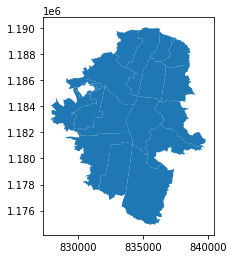

In [2]:
gdf = gpd.read_file('../../data/external/Perimetro_Urb_Med/Perimetro_Urb_Med.shp')
print(gdf.shape)
gdf.plot()

In [3]:
gdf = gdf.to_crs("EPSG:4326")

## Download raster

In [4]:
band_name_dict = {'nir':[False],
                      'red':[False],
                 'eq':["(nir-red)/(nir+red)"]}
index_analysis = 'ndvi'
tmp_dir = f'../../data/processed/tmp_{index_analysis}/'
res = [8,11] # 8, 11
freq = 'MS'
start_date = '2018-01-01'
end_date = '2022-12-31'
satellite = "sentinel-2-l2a"
save = False # True
del_data = False # True
city = 'Medellin'
query = {}


### Function

### step by step process

In [5]:
# Create buffer around hexagons
poly = gdf.to_crs("EPSG:6372").buffer(500)
poly = poly.to_crs("EPSG:4326")
poly = gpd.GeoDataFrame(geometry=poly).dissolve().geometry
# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

# Sets the coordinates for the area of interest
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

# create time of interest
time_of_interest = aup.create_time_of_interest(start_date, end_date, freq=freq)
# gathers items for time and area of interest
items = aup.gather_items(time_of_interest, area_of_interest, query=query, satellite=satellite)

date_list = aup.available_datasets(items, satellite)

# create dictionary from links
band_name_list = list(band_name_dict.keys())[:-1]
assets_hrefs = aup.link_dict(band_name_list, items, date_list)

# analyze available data according to raster properties
df_len, missing_months = aup.df_date_links(assets_hrefs, start_date, end_date, 
                                       band_name_list, freq)
aup.available_data_check(df_len, missing_months) # test for missing months

# creates raster and analyzes percentage of missing data points
df_len, missing_months = aup.df_date_links(assets_hrefs, start_date, end_date, 
                                       band_name_list, freq)
pct_missing = round(missing_months/len(df_len),2)*100
# if more than 50% of data is missing, raise error and print message
if pct_missing >= 50:
    raise AvailableData('Missing more than 50 percent of data points')

# raster cropping with bounding box from earlier 
bounding_box = gpd.GeoDataFrame(geometry=poly).envelope
gdf_bb = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])

# create GeoDataFrame to test nan values in raster
gdf_raster_test = gdf.to_crs("EPSG:6372").buffer(1)
gdf_raster_test = gdf_raster_test.to_crs("EPSG:4326")
gdf_raster_test = gpd.GeoDataFrame(geometry=gdf_raster_test).dissolve()

# raster creation


In [23]:
from func_timeout import func_timeout
import numpy as np
import rasterio
from tqdm import tqdm
from datetime import datetime
from dateutil.relativedelta import relativedelta


df_len['able_to_download'] = np.nan

i = 4

# check if file exists, for example in case of code crash
df_file_dir = tmp_dir+index_analysis+f'_{city}_dataframe.csv'
if os.path.exists(df_file_dir) == False: # Or folder, will return true or false
    df_len.to_csv(df_file_dir)
# create folder to store temporary raster files by iteration
tmp_raster_dir = tmp_dir+'temporary_files/'
if os.path.exists(tmp_raster_dir) == False: # Or folder, will return true or false
    os.mkdir(tmp_raster_dir)

df_raster = pd.read_csv(df_file_dir, index_col=False)

# binary id - checks if month could be processed
checker = 0

# gather month and year from df to save ndmi
month_ = df_raster.loc[df_raster.index==i].month.values[0]
year_ = df_raster.loc[df_raster.index==i].year.values[0]

# gather links for raster images
sample_date = datetime(year_, month_, 1)
first_day = sample_date + relativedelta(day=1)
last_day = sample_date + relativedelta(day=31)

# creates time range for a specific month
time_of_interest = [f"{year_}-{month_:02d}-{first_day.day:02d}/{year_}"+
                    f"-{month_:02d}-{last_day.day:02d}"]


# gather links for the date range
items = aup.gather_items(time_of_interest, area_of_interest, query=query, satellite=satellite)
# gather links from dates that are within date_list
assets_hrefs = aup.link_dict(band_name_list, items, date_list)
# create dataframe
#df_links = pd.DataFrame.from_dict(assets_hrefs, 
#                                orient='Index').reset_index().rename(columns={'index':'date'})


In [24]:
data_link = 0
bands_links = assets_hrefs[list(assets_hrefs.keys())[data_link]]
bands_links

{'nir': ['https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/N/VN/2018/05/29/S2A_MSIL2A_20180529T152641_N0212_R025_T18NVN_20201012T152604.SAFE/GRANULE/L2A_T18NVN_A015323_20180529T152640/IMG_DATA/R10m/T18NVN_20180529T152641_B08_10m.tif?st=2023-07-26T17%3A41%3A38Z&se=2023-07-27T18%3A26%3A38Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-07-27T14%3A44%3A14Z&ske=2023-08-03T14%3A44%3A14Z&sks=b&skv=2021-06-08&sig=sWIgIP6COqjVk9B3DdZzfqyoqBw2nHziBpxPeO6WSd8%3D',
  'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/N/VM/2018/05/29/S2A_MSIL2A_20180529T152641_N0212_R025_T18NVM_20201012T152608.SAFE/GRANULE/L2A_T18NVM_A015323_20180529T152640/IMG_DATA/R10m/T18NVM_20180529T152641_B08_10m.tif?st=2023-07-26T17%3A41%3A38Z&se=2023-07-27T18%3A26%3A38Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-07-27T14%3A44%3A14Z&ske=2023-08-03T14%3A44

In [25]:
raster_arrays = aup.mosaic_process_v2(bands_links, band_name_dict,
                     gdf_bb, tmp_raster_dir)

In [26]:
raster_arrays.keys()

dict_keys(['nir', 'red'])

In [27]:
raster_index = aup.calculate_raster_index(band_name_dict, raster_arrays)
raster_index

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)

In [ ]:
raster_index[raster_index == 0 ] = np.nan # change zero values to nan
raster_index = raster_index.astype('float32') # change data type to float32 to avoid fillnodata error

In [ ]:
from rasterio.fill import fillnodata

raster_fill = fillnodata(raster_index, mask=~np.isnan(raster_index),
                         max_search_distance=50, smoothing_iterations=0)

In [ ]:
out_meta = raster_arrays[list(raster_arrays.keys())[0]][2]

with rasterio.open(f"{tmp_raster_dir}{index_analysis}.tif",'w', **out_meta) as dest:
        dest.write(raster_fill)

        dest.close()

In [ ]:
raster_file = rasterio.open(f"{tmp_raster_dir}{index_analysis}.tif")

gdf_raster_test = gdf_raster_test.to_crs(raster_file.crs)

In [ ]:
try:
    # test for nan values within study area
    aup.raster_nan_test(gdf_raster_test,raster_file)

    # save raster to processing database
    with rasterio.open(f"{tmp_dir}{city}_{index_analysis}_{month_}_{year_}.tif",'w', **out_meta) as dest:
        dest.write(raster_fill)

        dest.close()
    checker = 1
    iter_count = 6
    delete_files_from_folder(tmp_raster_dir)
except:
    aup.delete_files_from_folder(tmp_raster_dir)

In [53]:
def calculate_raster_index(band_name_dict, rasters_arrays):
    """
    The function calculates the raster index according to a user equation. 
    If no equation is provided, the raster_array is returned.

    Args:
        band_name_dict (dict): dictionary containing the band names and the equation to be used
        raster_arrays (dict): dictionary containing the rasters numpy arrays

    Returns:
        np.array: resulting numpy array for the raster index
    """

    if len(band_name_dict['eq']) == 0:
        # if there is no equation the raster array is the result
        raster_idx = raster_arrays[list(raster_arrays.keys())[0]]
        return raster_idx

    # calculate raster index according to user equation
    for rb in rasters_arrays.keys():
        band_name_dict['eq'][0] = band_name_dict['eq'][0].replace(rb,f"ra['{rb}'][0]")

        global ra
    ra = rasters_arrays
    exec(f"raster_index = {band_name_dict['eq'][0]}", globals())
    # exec('myvar="boooh!"', globals())
    del ra

    return raster_index

In [45]:
band_name_dict = {'nir':[False],
                      'red':[False],
                 'eq':["(nir-red)/(nir+red)"]}
for rb in raster_arrays.keys():
    band_name_dict['eq'][0] = band_name_dict['eq'][0].replace(rb,str(raster_arrays[rb][0]))
band_name_dict['eq']

['([[[   0.    0.    0. ...    0.    0.    0.]\n  [   0.    0. 3060. ...    0.    0.    0.]\n  [   0.    0. 2934. ...    0.    0.    0.]\n  ...\n  [1014.  933.  993. ...    0.    0.    0.]\n  [   0.    0.    0. ...    0.    0.    0.]\n  [   0.    0.    0. ...    0.    0.    0.]]]-[[[  0.   0.   0. ...   0.   0.   0.]\n  [  0.   0. 458. ...   0.   0.   0.]\n  [  0.   0. 435. ...   0.   0.   0.]\n  ...\n  [794. 816. 816. ...   0.   0.   0.]\n  [  0.   0.   0. ...   0.   0.   0.]\n  [  0.   0.   0. ...   0.   0.   0.]]])/([[[   0.    0.    0. ...    0.    0.    0.]\n  [   0.    0. 3060. ...    0.    0.    0.]\n  [   0.    0. 2934. ...    0.    0.    0.]\n  ...\n  [1014.  933.  993. ...    0.    0.    0.]\n  [   0.    0.    0. ...    0.    0.    0.]\n  [   0.    0.    0. ...    0.    0.    0.]]]+[[[  0.   0.   0. ...   0.   0.   0.]\n  [  0.   0. 458. ...   0.   0.   0.]\n  [  0.   0. 435. ...   0.   0.   0.]\n  ...\n  [794. 816. 816. ...   0.   0.   0.]\n  [  0.   0.   0. ...   0.   0.   

In [46]:
exec(f"raster_index = {band_name_dict['eq'][0]}", globals())

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)

In [55]:
band_name_dict = {'nir':[False],
                      'red':[False],
                 'eq':["(nir-red)/(nir+red)"]}
raster_idx = calculate_raster_index(band_name_dict, raster_arrays)
raster_idx

array([[[    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan, 0.7397 , ...,     nan,     nan,     nan],
        [    nan,     nan, 0.742  , ...,     nan,     nan,     nan],
        ...,
        [0.1217 , 0.0669 , 0.09784, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]]],
      dtype=float16)

In [20]:
exec(f"bla={band_name_dict['eq'][0]}")

In [ ]:
# mosaic raster

iter_count = 1

while iter_count <= 5:

    # create skip date list used to analyze null values in raster
    skip_date_list = []

    #for data_link in range(len(df_links)):
    for data_link in range(len(assets_hrefs.keys())):

        # check if date contains null values within study area
        #if df_links.iloc[data_link]['date'] in skip_date_list:
        if list(assets_hrefs.keys())[data_link] in skip_date_list:
            continue

        try:
            #links_band_1 = df_links.iloc[data_link][list(band_name_dict.keys())[0]]
            #links_band_2 = df_links.iloc[data_link][list(band_name_dict.keys())[1]]
            bands_links = assets_hrefs[list(assets_hrefs.keys())[data_link]]

            rasters_arrays = func_timeout(time_exc_limit, aup.mosaic_process_v2,
                                                                        args=(bands_links,
                                                                              band_name_dict, 
                                                                              gdf_bb, tmp_raster_dir))
            out_meta = rasters_arrays[list(rasters_arrays.keys())[0]][2]

            # calculate raster index
            raster_index = calculate_raster_index(band_name_dict, rasters_arrays)
            del raster_arrays

            raster_index[raster_index == 0 ] = np.nan # change zero values to nan
            raster_index = raster_index.astype('float32') # change data type to float32 to avoid fillnodata error

            raster_fill = fillnodata(raster_index, mask=~np.isnan(raster_index),
                                max_search_distance=50, smoothing_iterations=0)

            with rasterio.open(f"{tmp_raster_dir}{index_analysis}.tif",'w', **out_meta) as dest:
                    dest.write(raster_fill)

                    dest.close()

            raster_file = rasterio.open(f"{tmp_raster_dir}{index_analysis}.tif")

            gdf_raster_test = gdf_raster_test.to_crs(raster_file.crs)

            try:
                # test for nan values within study area
                raster_nan_test(gdf_raster_test,raster_file)


                # save raster to processing database
                with rasterio.open(f"{tmp_dir}{city}_{index_analysis}_{month_}_{year_}.tif",'w', **out_meta) as dest:
                    dest.write(raster_fill)

                    dest.close()

                checker = 1
                iter_count = 6
                delete_files_from_folder(tmp_raster_dir)
                break
            except:
                skip_date_list.append(assets_hrefs[list(assets_hrefs.keys())[data_link]])
                delete_files_from_folder(tmp_raster_dir)

        except:
            delete_files_from_folder(tmp_raster_dir)
            
    iter_count = iter_count + 1

if checker==0:
    df_raster.loc[df_raster.index==i,'data_id']=0
    df_raster.loc[df_raster.index==i,'able_to_download']=0
    df_raster.to_csv(df_file_dir, index=False)

### Donwload raster function

In [7]:
df_len = aup.download_raster_from_pc(gdf, index_analysis, city, freq,
                                        start_date, end_date, tmp_dir, 
                                     band_name_dict,satellite=satellite)

100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:34<00:00,  1.75it/s]


AttributeError: 'DataFrame' object has no attribute 'raster_row'